W projekcie powinny znale≈∫ƒá siƒô nastƒôpujƒÖce elementy:

- wstƒôp zawierajƒÖcy cel pracy,
- opis i wstƒôpna analiza wykorzystywanych danych (≈∫r√≥d≈Ço danych, podstawowe statystyki, wykresy, wsp√≥≈Çczynniki zmienno≈õci, korelacje, warto≈õci odstajƒÖce itp.),
- zastosowanie minimum dw√≥ch technik porzƒÖdkowania liniowego (wzorcowƒÖ i bezwzorcowƒÖ),
- zastosowanie minimum dw√≥ch technik analizy skupie≈Ñ (grupowanie podzia≈Çowe i hierarchiczne), w tym uzasadnienie wyboru wybranej liczby skupie≈Ñ,
- interpretacja uzyskanych wynik√≥w:
  - porzƒÖdkowanie liniowe: ocena ranking√≥w, podobie≈Ñstwo wynik√≥w (korelacja), grupowanie wg ≈õredniej itd.,
  - analiza skupie≈Ñ: interpretacja poszczeg√≥lnych klastr√≥w, por√≥wnanie wynik√≥w grupowania wykonanego r√≥≈ºnymi metodami,
- podsumowanie.

Sprawozdanie z projektu powinno skupiaƒá siƒô przede wszystkim na analizie danych i wynik√≥w,  a w mniejszym stopniu na sposobie implementacji poszczeg√≥lnych metod.

W projekcie wykorzystujƒô sw√≥j w≈Çasny zbi√≥r, stworzony na podstawie cen kryptowaluty Bitcoin (open, high, low, close, volume).

Zbi√≥r danych zawiera takie cechy jak:

| Cecha                  | Skr√≥t              | Jednostka | Opis                                     |
| ---------------------- | ------------------ | --------- | ---------------------------------------- |
| ≈öredni zasiƒôg ≈õwiecy   | `range_mean`       | USD       | zmienno≈õƒá surowa                         |
| ≈öredni wolumen         | `volume_mean`      | BTC       | aktywno≈õƒá rynku                          |
| ATR (30min)            | `atr_mean`         | USD       | wyg≈Çadzona zmienno≈õƒá                     |
| ≈örednia % zmiana ceny  | `return_mean`      | %         | kierunek i dynamika                      |
| Odchylenie std % zmian | `return_std`       | %         | zmienno≈õƒá zwrot√≥w                        |
| Asymetria zwrot√≥w      | `skewness`         | bezj.     | kierunkowa przewaga (bycza/nied≈∫wiedzia) |
| Spiczasto≈õƒá zwrot√≥w    | `kurtosis`         | bezj.     | wystƒôpowanie ekstrem√≥w                   |
| Sharpe ratio           | `sharpe`           | bezj.     | relacja zysk‚Äìryzyko                      |


| Cecha                  | Skr√≥t              | Jednostka | Opis                                     |
| ---------------------- | ------------------ | --------- | ---------------------------------------- |
| Ile zajmuje knot       | `wick_ratio`       | 0-1       | Czy ruch by≈Ç szaroany                    |
| Ile zajmuje body       | `body_ratio`  	  | 0-1       | Czy ruch by≈Ç p≈Çynny                      |
| Stabilo≈õƒá trendu       | `trend_stability`  | 0-1       | Czy trend stabliny / szaroany            |
| Zmienno≈õƒá Wewnƒôtrzna   | `micro_vol`  	  | 0-1       | mikro-zmienno≈õƒá wewnƒôtrzna            	 |

# 1. Przygtowanie danych

Z racji i≈º zbi√≥r oraz cechy wymy≈õi≈Çem sam to te≈º sam musia≈Çem je wyliczyƒá, poni≈ºsze kilka blok√≥w nale≈ºy do podstawowego wyliczania danych.

In [174]:
import pandas as pd
from ta.volatility import AverageTrueRange
from sklearn.preprocessing import StandardScaler

In [175]:
df = pd.read_csv('BTCUSDT_1m.csv')

In [176]:
# Upewniam siƒô, ≈ºe pole daty ma typ daty
df['datetime'] = pd.to_datetime(df['datetime'])

df = df.sort_values('datetime')

# Ustawiam datƒô jako indeks
df = df.set_index('datetime')

print(df.head())

                      timestamp      open      high       low     close  \
datetime                                                                  
2024-12-31 23:00:00  1735686000  93488.83  93488.84  93445.45  93445.45   
2024-12-31 23:01:00  1735686060  93445.46  93480.50  93405.27  93417.72   
2024-12-31 23:02:00  1735686120  93417.71  93475.45  93417.71  93475.45   
2024-12-31 23:03:00  1735686180  93475.45  93569.44  93475.45  93507.66   
2024-12-31 23:04:00  1735686240  93507.66  93535.02  93388.81  93417.68   

                       volume  
datetime                       
2024-12-31 23:00:00   8.37480  
2024-12-31 23:01:00  13.65448  
2024-12-31 23:02:00   3.38207  
2024-12-31 23:03:00   8.35472  
2024-12-31 23:04:00  19.76090  


In [177]:
# Agreagujƒô dane do 30-minutowych ≈õwiec
df_30m = df.resample('30min').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()

In [178]:
# Zasiƒôg ≈õwiecy
df_30m['range'] = df_30m['high'] - df_30m['low']

# Zwrot procentowy
df_30m['return'] = (df_30m['close'] - df_30m['open']) / df_30m['open'] * 100

atr_indicator = AverageTrueRange(df_30m['high'], df_30m['low'], df_30m['close'], window=14)
df_30m['ATR'] = atr_indicator.average_true_range()

# ≈ªeby trzymaƒá info o wszytskich zwrotach 
df_30m['is_positive'] = df_30m['return'] > 0

In [179]:
# Tworzƒô etykiety, po to by m√≥c potem pogrupowaƒá dane po ka≈ºdej p√≥lgodzinie

# Godzina i p√≥≈Çgodzina
df_30m['hour'] = df_30m.index.hour
df_30m['minute'] = df_30m.index.minute

# Nazwa przedzia≈Çu (np. "13:00-13:30")
df_30m['interval'] = df_30m['hour'].astype(str).str.zfill(2) + ':' + df_30m['minute'].astype(str).str.zfill(2)

# print(df_30m.tail(30))


In [180]:
# Grupujƒô po p√≥≈Çgodzinie, kt√≥rƒÖ powy≈ºej zdefiniowa≈Çem
grouped = df_30m.groupby('interval')

# Agregacja miar
stats = grouped.agg(
    range_mean=('range', 'mean'),
    volume_mean=('volume', 'mean'),
    atr_mean=('ATR', 'mean'),
    return_mean=('return', 'mean'),
    return_std=('return', 'std'),
    pos_count=('is_positive', 'sum'),
    count=('is_positive', 'count'),
    skewness=('return', pd.Series.skew),
    kurtosis=('return', pd.Series.kurtosis)
)

# Sharpe ratio
stats['sharpe'] = stats['return_mean'] / stats['return_std']

# Liczba dni z dodatnim wynikiem (%)
stats['pos_ratio'] = stats['pos_count'] / stats['count'] * 100


In [181]:
print(stats.head(48))
# stats.to_csv('btc_30m_stats.csv', index=True)

          range_mean  volume_mean    atr_mean  return_mean  return_std  \
interval                                                                 
00:00     443.155404   453.288487  439.317716    -0.021828    0.342737   
00:30     441.916561   409.842869  439.316009    -0.015770    0.304417   
01:00     444.037263   404.903983  439.505600    -0.011151    0.343501   
01:30     442.851684   439.359939  439.641712     0.001679    0.401351   
02:00     427.447930   405.261966  438.717948     0.020526    0.283952   
02:30     384.737088   395.498296  434.771367    -0.004216    0.271403   
03:00     360.418982   357.037946  429.377240    -0.000010    0.254004   
03:30     311.572526   330.170267  420.921785    -0.005945    0.228253   
04:00     319.927123   313.531025  413.668041     0.014175    0.208746   
04:30     319.142281   316.730416  406.856542     0.015871    0.237203   
05:00     311.905965   323.462772  399.977641     0.005250    0.231295   
05:30     286.804737   302.461444  393

# PorzƒÖdkowanie Liniowe

## Metoda bezwzorcowa

Jako metodƒô bezwzorcowƒÖ wybra≈Çem **metodƒô porzƒÖdkowania liniowego**.
W celu stworzenia rankingu rozpoczƒÖ≈Çem od odpowiedniego dostosowania danych.

Celem przygotowanego rankingu jest okre≈õlenie, **kt√≥re godziny sƒÖ najbardziej aktywne** (pod wzglƒôdem zwrotu i wolumenu) oraz **najbardziej kierunkowe** (czyli wykazujƒÖce wyra≈∫ne wzrosty lub spadki).

Do przeprowadzenia rankingu wybra≈Çem podzbi√≥r zmiennych, kt√≥re ‚Äì z logicznego punktu widzenia ‚Äì najlepiej opisujƒÖ to zjawisko:

| Zmienna       | Typ          | Co mierzy            |
| ------------- | ------------ | -------------------- |
| `range_mean`  | stymulanta   | zmienno≈õƒá surowa     |
| `volume_mean` | stymulanta   | aktywno≈õƒá rynku      |
| `atr_mean`    | stymulanta   | wyg≈Çadzona zmienno≈õƒá |
| `abs_sharpe`  | stymulanta   | kierunkowo≈õƒá ruchu   |
| `return_std`  | destymulanta | chaos / losowo≈õƒá     |

Jak mo≈ºna zauwa≈ºyƒá, pojawi≈Ça siƒô nowa zmienna `abs_sharpe`.
Jak sama nazwa wskazuje, jest to po prostu wsp√≥≈Çczynnik Sharpe‚Äôa, dla kt√≥rego zastosowano warto≈õƒá bezwzglƒôdnƒÖ.
Nie mo≈ºna uznaƒá tej zmiennej za **nominantƒô**, poniewa≈º w jej przypadku po≈ºƒÖdane sƒÖ warto≈õci **jak najbardziej oddalone od zera**.
Oznacza to, ≈ºe optimum nie jest pojedyncze, lecz **podw√≥jne** ‚Äì mo≈ºe nim byƒá zar√≥wno **wysokie odchylenie ujemne**, jak i **wysokie odchylenie dodatnie**.
Z tego wzglƒôdu logiczne jest zastosowanie warto≈õci bezwzglƒôdnej, aby uchwyciƒá si≈Çƒô kierunkowo≈õci niezale≈ºnie od jej znaku.

Tak≈ºe `return_std` zosta≈Ço uznanƒô za destymuantƒô, poniewa≈º chcemy by nasze zwroty by≈Çy bardziej stabilne i przewidywalne ni≈º 'rozrzucone'.

In [182]:
# Dodajƒô nowƒÖ kolumnƒô abs_sharpe
stats['abs_sharpe'] = stats['sharpe'].abs()

# Zmieniam destymuklantƒô na stymulantƒô
stats['return_std_stim'] = -stats['return_std']

# WYbieram cechy jakie chce uwzglƒôdniƒá przy towrzeniu tego rankingu
features = ['range_mean', 'volume_mean', 'atr_mean', 'abs_sharpe', 'return_std_stim']

# Standaryzacja
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(stats[features]),
    columns=features,
    index=stats.index
)

X_scaled.head()

range_mean  volume_mean  atr_mean  abs_sharpe  return_std_stim
interval                                                                
00:00       0.242293     0.096020  0.557834    0.428301        -0.244532
00:30       0.230333    -0.210685  0.557790    0.130102         0.174726
01:00       0.250806    -0.245552  0.562613   -0.355268        -0.252883
01:30       0.239361    -0.002309  0.566075   -1.064973        -0.885820
02:00       0.090656    -0.243024  0.542577    0.644145         0.398630

In [183]:
# Obliczam wynik sumaryczny (prosty ranking bezwzorcowy)
stats['score_simple'] = X_scaled.sum(axis=1)

ranking = stats[['score_simple']].sort_values(by='score_simple', ascending=False)

print(ranking.head(10))

          score_simple
interval              
15:00         3.650088
17:00         3.420567
13:30         3.053776
20:00         2.588763
19:00         2.477828
15:30         2.454647
14:30         2.439673
16:30         2.336674
23:00         1.923677
16:00         1.864464


Teraz zwizualizujƒô pierwszƒÖ wersjƒô rankingu bez wprowadzonych rang

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(df, column, title, cmap='coolwarm', figsize=(10, 5)):
    plt.figure(figsize=figsize)
    sns.heatmap(df[[column]].T, cmap=cmap, cbar=True)
    plt.title(title)
    plt.xlabel('Godzina (interval)')
    plt.ylabel('')
    plt.show()

def plot_heatmaps_stacked(df, columns, titles=None, cmap='coolwarm', figsize=(12, 6), shared_scale=True):
    """
    Rysuje kilka heatmap jedna pod drugƒÖ (do por√≥wnania).

    Parameters
    ----------
    df : pd.DataFrame
        Dane zawierajƒÖce kolumny do wizualizacji.
    columns : list[str]
        Lista nazw kolumn, kt√≥re majƒÖ zostaƒá przedstawione.
    titles : list[str], optional
        Lista tytu≈Ç√≥w dla poszczeg√≥lnych heatmap (musi mieƒá tƒô samƒÖ d≈Çugo≈õƒá co `columns`).
    cmap : str, optional
        Paleta kolor√≥w (default: 'coolwarm').
    figsize : tuple, optional
        Rozmiar figury (default: (12, 6)).
    shared_scale : bool, optional
        Je≈õli True ‚Äì wsp√≥lne vmin/vmax dla wszystkich (bezwzglƒôdne por√≥wnanie).
        Je≈õli False ‚Äì ka≈ºda heatmapa ma w≈Çasny zakres kolor√≥w (por√≥wnanie wzorc√≥w).
    """

    n = len(columns)
    if titles is None:
        titles = columns

    # Je≈õli skala wsp√≥lna
    vmin = vmax = None
    if shared_scale:
        all_values = df[columns].values.flatten()
        vmin, vmax = all_values.min(), all_values.max()

    fig, axes = plt.subplots(n, 1, figsize=figsize, sharex=True)

    if n == 1:
        axes = [axes]

    for ax, col, title in zip(axes, columns, titles):
        data = df[[col]].T
        sns.heatmap(
            data,
            cmap=cmap,
            cbar=True,
            ax=ax,
            vmin=vmin,
            vmax=vmax
        )
        ax.set_title(title)
        ax.set_xlabel('Godzina (interval)')
        ax.set_ylabel('')

    plt.tight_layout()
    plt.show()

Teraz w celu udoskonalenia nadam rangi poszczeg√≥lnym cechƒÖ w celu potencalnego ulepszenia rankingu poprzez mocniejsze zwracanie uwagi na potencjalnie wa≈ºnijesze cechy.

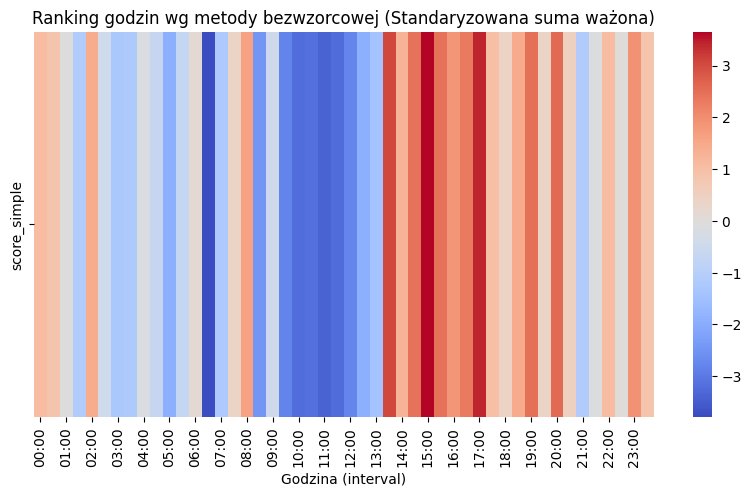

In [185]:
plot_heatmap(
    stats,
    column='score_simple',
    title='Ranking godzin wg metody bezwzorcowej (Standaryzowana suma wa≈ºona)'
)

## Metoda bezwzorcowa

W metodzie porzƒÖdkowania liniowego ranking godzin opiera siƒô na prostym zsumowaniu standaryzowanych warto≈õci cech diagnostycznych.
Godziny o najwy≈ºszych warto≈õciach cech stymulujƒÖcych i najni≈ºszej zmienno≈õci uzyska≈Çy najwy≈ºsze wyniki.
Najlepsze przedzia≈Çy godzinowe skupiajƒÖ siƒô wok√≥≈Ç popo≈Çudnia, natomiast godziny poranne i nocne charakteryzujƒÖ siƒô ni≈ºszymi ocenami.

In [186]:
# Wiƒôksza waga dla zwrotu
weights = {
    'range_mean': 2.0,
    'volume_mean': 1.0,
    'atr_mean': 1.5,
    'abs_sharpe': 2.0,
    'return_std_stim': 1.0
}

# Oblicz ranking wa≈ºony
stats['score_weighted'] = sum(X_scaled[col] * w for col, w in weights.items())


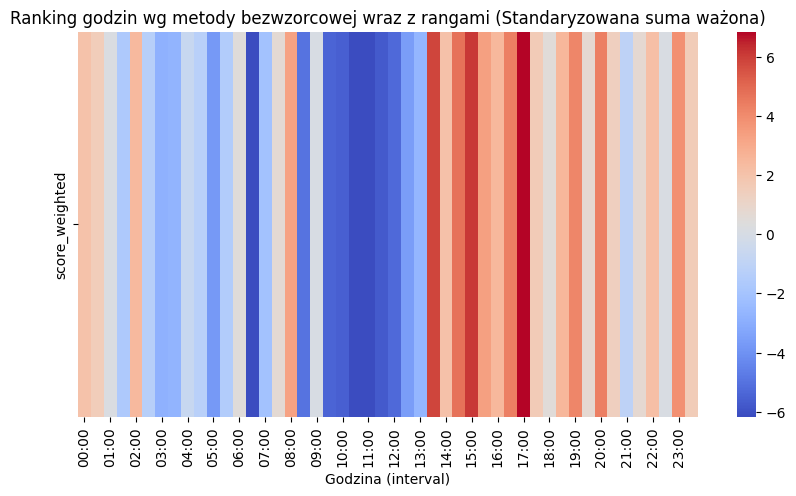

In [187]:
plot_heatmap(
    stats,
    column='score_weighted',
    title='Ranking godzin wg metody bezwzorcowej wraz z rangami (Standaryzowana suma wa≈ºona)'
)

# Metoda bezwzorcowa z wagami

Po uwzglƒôdnieniu wag poszczeg√≥lnych zmiennych ranking sta≈Ç siƒô bardziej zr√≥≈ºnicowany.
Wagi zwiƒôkszy≈Çy wp≈Çyw kluczowych czynnik√≥w (np. stabilno≈õci lub wolumenu), przez co r√≥≈ºnice miƒôdzy godzinami sƒÖ bardziej wyra≈∫ne.
Najlepsze godziny pozosta≈Çy zbli≈ºone do poprzedniego zestawienia, lecz ich przewaga nad pozosta≈Çymi jest silniej zaznaczona.

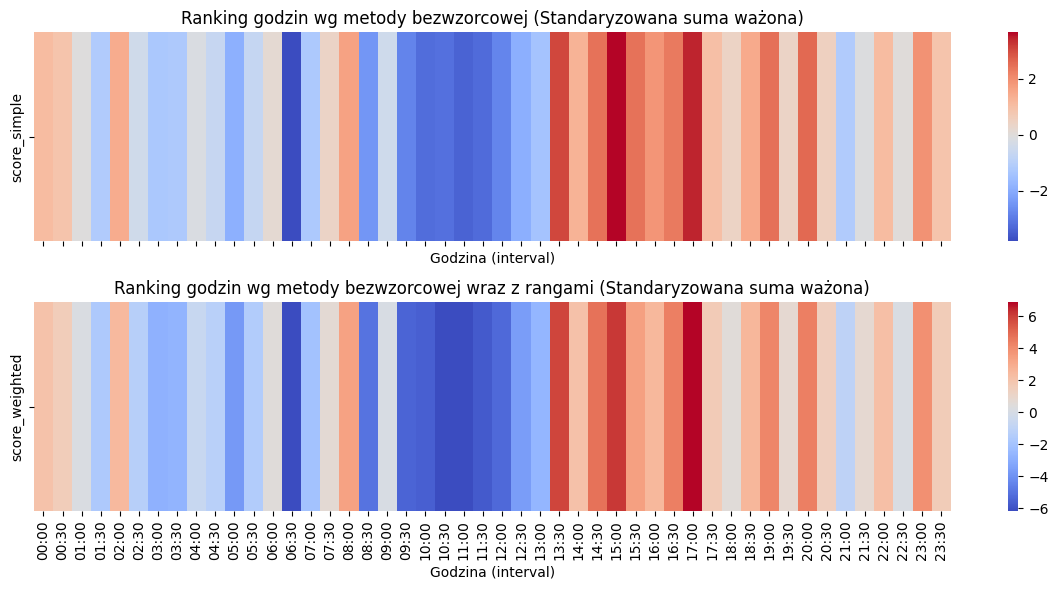

In [188]:
plot_heatmaps_stacked(
    stats,
    columns=['score_simple', 'score_weighted'],
    titles=[
        'Ranking godzin wg metody bezwzorcowej (Standaryzowana suma wa≈ºona)',
        'Ranking godzin wg metody bezwzorcowej wraz z rangami (Standaryzowana suma wa≈ºona)'
    ],
    shared_scale=False
)

# Por√≥wnanie metod a) i b)

Obie metody wskazujƒÖ podobny uk≈Çad najlepszych i najs≈Çabszych godzin, co potwierdza stabilno≈õƒá wniosk√≥w.
Zastosowanie wag nie zmieni≈Ço kierunku ocen, lecz wzmocni≈Ço kontrasty i lepiej odda≈Ço znaczenie poszczeg√≥lnych czynnik√≥w w kszta≈Çtowaniu rankingu.

# Metoda wzorcowa



In [189]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Wybieram cechy diagnostyczne
features = ['range_mean', 'volume_mean', 'atr_mean', 'abs_sharpe', 'return_std_stim']

# ==========================================================
# 2Ô∏è‚É£ Normalizacja (0‚Äì1)
# ==========================================================

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(stats[features]),
    columns=features,
    index=stats.index
)

# ==========================================================
# 3Ô∏è‚É£ Wyznaczenie wzorca i antywzorca
# ==========================================================

# Wzorzec = maksymalne warto≈õci
pattern = X_scaled.max()

# Antywzorzec = minimalne warto≈õci
anti_pattern = X_scaled.min()

# ==========================================================
# 4Ô∏è‚É£ Odleg≈Ço≈õci od wzorca i antywzorca
# ==========================================================

# Odleg≈Ço≈õƒá euklidesowa od wzorca (im mniejsza tym lepiej)
stats['d_plus'] = np.sqrt(((X_scaled - pattern) ** 2).sum(axis=1))

# Odleg≈Ço≈õƒá od antywzorca (im wiƒôksza tym lepiej)
stats['d_minus'] = np.sqrt(((X_scaled - anti_pattern) ** 2).sum(axis=1))

# ==========================================================
# 5Ô∏è‚É£ Wska≈∫nik Hellwiga (miara blisko≈õci do wzorca)
# ==========================================================

stats['score_hellwig'] = stats['d_minus'] / (stats['d_plus'] + stats['d_minus'])

# ==========================================================
# 6Ô∏è‚É£ Ranking godzin wg metody wzorcowej
# ==========================================================

ranking_hellwig = stats[['score_hellwig']].sort_values(by='score_hellwig', ascending=False)

print(ranking_hellwig.head(10))

          score_hellwig
interval               
17:00          0.601872
15:00          0.591018
20:00          0.558944
16:30          0.554736
19:00          0.552381
15:30          0.549132
13:30          0.547466
14:30          0.534792
16:00          0.525435
23:00          0.524377


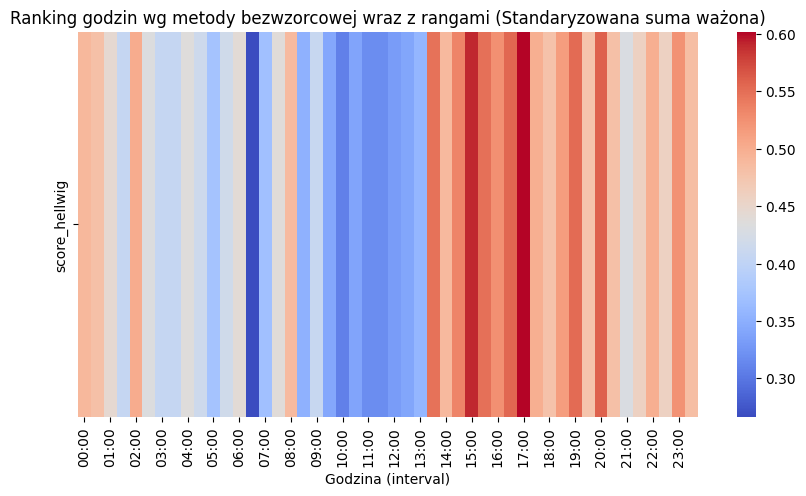

In [190]:
plot_heatmap(
    stats,
    column='score_hellwig',
    title='Ranking godzin wg metody bezwzorcowej wraz z rangami (Standaryzowana suma wa≈ºona)'
)

# Metoda wzorcowa Hellwiga

Metoda Hellwiga ocenia ka≈ºdƒÖ godzinƒô wzglƒôdem wzorca o najlepszych warto≈õciach wszystkich cech.
Najwy≈ºsze warto≈õci wska≈∫nika syntetycznego (blisko wzorca) uzyska≈Çy godziny z r√≥wnowagƒÖ miƒôdzy wysokimi wynikami a niskƒÖ zmienno≈õciƒÖ.
Ranking potwierdza przewagƒô godzin popo≈Çudniowych, jednak rozk≈Çad ocen jest bardziej wyg≈Çadzony ni≈º w metodach bezwzorcowych.

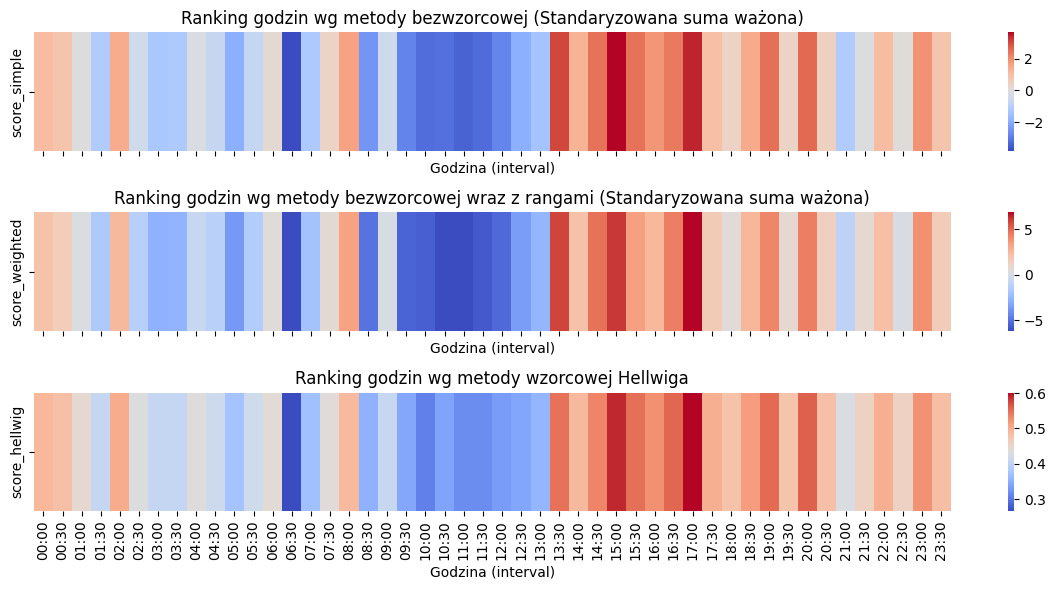

In [191]:
plot_heatmaps_stacked(
    stats,
    columns=['score_simple', 'score_weighted', 'score_hellwig'],
    titles=[
        'Ranking godzin wg metody bezwzorcowej (Standaryzowana suma wa≈ºona)',
        'Ranking godzin wg metody bezwzorcowej wraz z rangami (Standaryzowana suma wa≈ºona)',
        'Ranking godzin wg metody wzorcowej Hellwiga'
    ],
    shared_scale=False
)

# Por√≥wnanie metod a), b) i d)

Wszystkie trzy metody wykazujƒÖ sp√≥jny trend ‚Äî najwy≈ºsze oceny przypadajƒÖ na godziny popo≈Çudniowe, najni≈ºsze na poranne.
Metoda Hellwiga potwierdza wyniki porzƒÖdkowania liniowego, ale uwzglƒôdnia relatywnƒÖ odleg≈Ço≈õƒá od wzorca, przez co jest bardziej odporna na skrajne warto≈õci.
Zastosowanie wag w metodzie bezwzorcowej zwiƒôkszy≈Ço kontrast, natomiast metoda wzorcowa da≈Ça bardziej zr√≥wnowa≈ºony obraz rankingu.

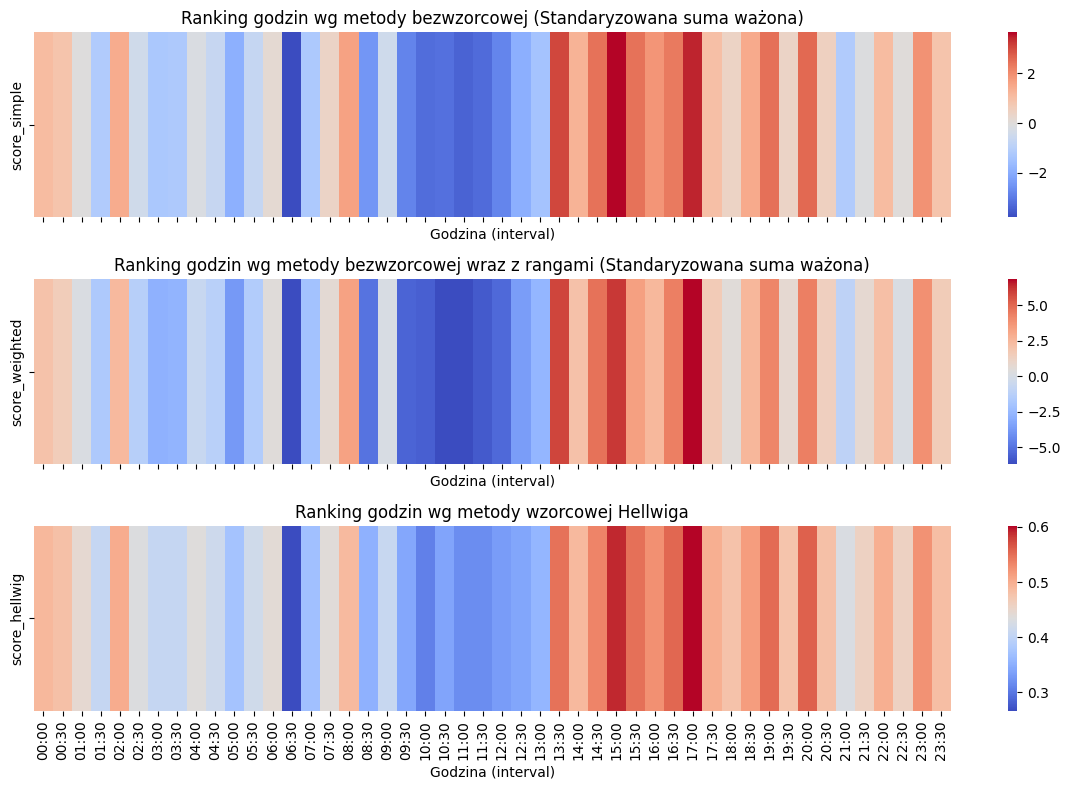

In [192]:
def plot_heatmaps(df, score_cols, titles, figsize=(12, 8)):
    n = len(score_cols)
    fig, axes = plt.subplots(n, 1, figsize=figsize, sharex=True)

    for i, (ax, col, title) in enumerate(zip(axes, score_cols, titles)):
        sns.heatmap(df[[col]].T, cmap='coolwarm', cbar=True, ax=ax)
        ax.set_title(title)
        ax.set_xlabel('Godzina (interval)')
        ax.set_ylabel('')

    plt.tight_layout()
    plt.show()


plot_heatmaps(
    stats,
    score_cols=['score_simple', 'score_weighted', 'score_hellwig'],
    titles=[
        'Ranking godzin wg metody bezwzorcowej (Standaryzowana suma wa≈ºona)',
        'Ranking godzin wg metody bezwzorcowej wraz z rangami (Standaryzowana suma wa≈ºona)',
        'Ranking godzin wg metody wzorcowej Hellwiga'
    ]
)

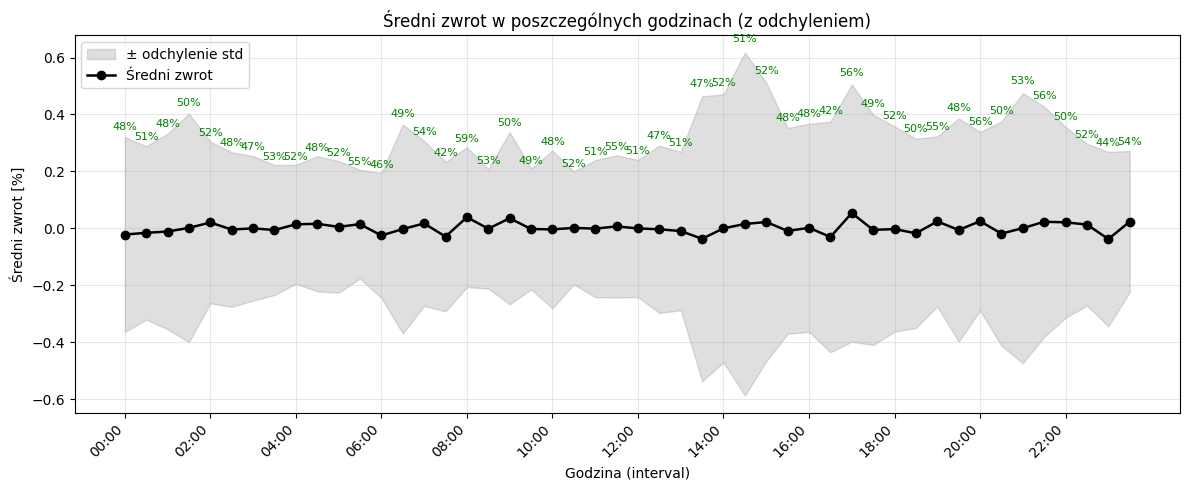

In [193]:
def plot_returns_detailed(df, return_mean_col='return_mean', return_std_col='return_std',
                          pos_ratio_col='pos_ratio', figsize=(12, 5)):
    """
    Wykres ≈õrednich zwrot√≥w z odchyleniem standardowym i procentem dodatnich godzin.

    Parameters
    ----------
    df : pd.DataFrame
        Dane z kolumnami zwrot√≥w, odchyle≈Ñ i procentem dodatnich godzin.
    return_mean_col : str
        Kolumna ze ≈õrednim zwrotem [%].
    return_std_col : str
        Kolumna z odchyleniem standardowym [%].
    pos_ratio_col : str
        Kolumna z procentem dodatnich godzin.
    figsize : tuple
        Rozmiar figury.
    """

    fig, ax = plt.subplots(figsize=figsize)

    x = np.arange(len(df))
    hours = df.index

    mean = df[return_mean_col]
    std = df[return_std_col]

    # Szare t≈Ço ¬± odchylenie
    ax.fill_between(x, mean - std, mean + std, alpha=0.25, color='gray', label='¬± odchylenie std')

    # Czarna linia ≈õrednich zwrot√≥w
    ax.plot(x, mean, color='black', marker='o', linewidth=1.8, label='≈öredni zwrot')

    # Czytelna o≈õ X
    step = max(1, len(hours) // 12)
    ax.set_xticks(x[::step])
    ax.set_xticklabels(hours[::step], rotation=45, ha='right')

    # Opisy
    ax.set_title('≈öredni zwrot w poszczeg√≥lnych godzinach (z odchyleniem)')
    ax.set_xlabel('Godzina (interval)')
    ax.set_ylabel('≈öredni zwrot [%]')
    ax.grid(alpha=0.3)
    ax.legend()

    # Dodanie informacji o procentach pozytywnych godzin
    if pos_ratio_col in df.columns:
        for i, (y, ratio) in enumerate(zip(mean, df[pos_ratio_col])):
            ax.text(i, y + std.iloc[i] * 1.05, f"{ratio:.0f}%", ha='center', va='bottom', fontsize=8, color='green')

    plt.tight_layout()
    plt.show()


plot_returns_detailed(stats)

### ≈öredni zwrot (`czarna linia`)

≈örednie zwroty w poszczeg√≥lnych p√≥≈Çgodzinach sƒÖ **bliskie zera**, co sugeruje brak wyra≈∫nej przewagi jednej pory dnia.
R√≥≈ºnice miƒôdzy godzinami sƒÖ niewielkie, a te kt√≥re wystƒôpujƒÖ nazwa≈Çbym szumem na niskim interwale.


### Zmienno≈õƒá (`szare pole ‚Äì odchylenie std`)

Zakres szarego pola pokazuje, ≈ºe **w wiƒôkszo≈õci godzin zmienno≈õƒá utrzymuje siƒô na umiarkowanym poziomie (ok. ¬±0.3‚Äì0.5%)**.
Najwiƒôksze odchylenia widoczne sƒÖ w godzinach **oko≈Ço 13:30‚Äì15:30** (pre market i otwarcie sesji ameryka≈Ñskiej)


### Procent dodatnich przypadk√≥w (`zielone etykiety`)

Wiƒôkszo≈õƒá godzin ma **oko≈Ço 48‚Äì55% ≈õwiec wzrostowych**, czyli rynkowo neutralny rozk≈Çad ‚Äî brak silnej asymetrii.
Godziny z **wy≈ºszym udzia≈Çem pozytywnych zwrot√≥w (55‚Äì59%)** mogƒÖ wskazywaƒá na **czasowƒÖ przewagƒô popytu** (np. po publikacjach lub sesjach USA).
Z kolei godziny **poni≈ºej 45%** sugerujƒÖ czƒôstsze spadki i dominacjƒô poda≈ºy.


### Podsumowanie og√≥lne

* Rynek jest **w du≈ºej mierze losowy intraday**, ale pewne godziny (szczeg√≥lnie popo≈Çudniowe) oferujƒÖ **wiƒôcej okazji** przy wy≈ºszym ryzyku.
* Brak wyra≈∫nej przewagi w samych ≈õrednich zwrotach oznacza, ≈ºe **sama pora dnia nie jest wystarczajƒÖcym predyktorem kierunku**.

In [194]:
def group_by_mean(x):
    if x >= mean_val + std_val:
        return 'bardzo dobre'
    elif x >= mean_val:
        return 'dobre'
    elif x >= mean_val - std_val:
        return '≈õrednie'
    else:
        return 's≈Çabe'

col = 'score_weighted'
mean_val = stats[col].mean()
std_val = stats[col].std()

stats['group_weighted'] = stats[col].apply(group_by_mean)

print(stats['group_weighted'])

interval
00:00           dobre
00:30           dobre
01:00           dobre
01:30         ≈õrednie
02:00           dobre
02:30         ≈õrednie
03:00         ≈õrednie
03:30         ≈õrednie
04:00         ≈õrednie
04:30         ≈õrednie
05:00           s≈Çabe
05:30         ≈õrednie
06:00           dobre
06:30           s≈Çabe
07:00         ≈õrednie
07:30           dobre
08:00           dobre
08:30           s≈Çabe
09:00           dobre
09:30           s≈Çabe
10:00           s≈Çabe
10:30           s≈Çabe
11:00           s≈Çabe
11:30           s≈Çabe
12:00           s≈Çabe
12:30           s≈Çabe
13:00         ≈õrednie
13:30    bardzo dobre
14:00           dobre
14:30    bardzo dobre
15:00    bardzo dobre
15:30           dobre
16:00           dobre
16:30    bardzo dobre
17:00    bardzo dobre
17:30           dobre
18:00           dobre
18:30           dobre
19:00    bardzo dobre
19:30           dobre
20:00    bardzo dobre
20:30           dobre
21:00         ≈õrednie
21:30           dobre
22:

In [195]:
col = 'score_hellwig'
mean_val = stats[col].mean()
std_val = stats[col].std()

stats['group_hellwig'] = stats[col].apply(group_by_mean)

print(stats['group_hellwig'])

interval
00:00           dobre
00:30           dobre
01:00         ≈õrednie
01:30         ≈õrednie
02:00           dobre
02:30         ≈õrednie
03:00         ≈õrednie
03:30         ≈õrednie
04:00         ≈õrednie
04:30         ≈õrednie
05:00         ≈õrednie
05:30         ≈õrednie
06:00         ≈õrednie
06:30           s≈Çabe
07:00         ≈õrednie
07:30         ≈õrednie
08:00           dobre
08:30           s≈Çabe
09:00         ≈õrednie
09:30           s≈Çabe
10:00           s≈Çabe
10:30           s≈Çabe
11:00           s≈Çabe
11:30           s≈Çabe
12:00           s≈Çabe
12:30           s≈Çabe
13:00           s≈Çabe
13:30    bardzo dobre
14:00           dobre
14:30    bardzo dobre
15:00    bardzo dobre
15:30    bardzo dobre
16:00           dobre
16:30    bardzo dobre
17:00    bardzo dobre
17:30           dobre
18:00           dobre
18:30           dobre
19:00    bardzo dobre
19:30           dobre
20:00    bardzo dobre
20:30           dobre
21:00         ≈õrednie
21:30           dobre

### Interpretacja

Pogrupowanie wynik√≥w w porsty spos√≥b na 4 grupy potiwerdza i≈º najabrdziej aktywne i potencjalnie najlepsze godziny do handlowania na gie≈Çdzie to sƒÖ godziny popo≈Çudniowe w okolicy otwarcia Nowojorskiej sesji.

# Analiza skupie≈Ñ

Celem tej czƒô≈õci jest zidentyfikowanie grup godzin (interwa≈Ç√≥w czasowych), kt√≥re majƒÖ podobne w≈Ça≈õciwo≈õci rynkowe np. podobnƒÖ zmienno≈õƒá, aktywno≈õƒá itp.
W przeciwie≈Ñstwie do metod porzƒÖdkowania (kt√≥re tworzƒÖ ranking liniowy), analiza skupie≈Ñ nie porzƒÖdkuje, tylko grupuje obserwacje na podstawie ich podobie≈Ñstwa.

Do przeprowadzenia grupowania wybra≈Çem nastƒôpujacy podzbi√≥r zmiennych

| Zmienna       | Co mierzy                  |
| ------------- | -------------------------- |
| `range_mean`  | zmienno≈õƒá surowa           |
| `volume_mean` | aktywno≈õƒá rynku            |
| `atr_mean`    | wyg≈Çadzona zmienno≈õƒá       |
| `abs_sharpe`  | kierunkowo≈õƒá ruchu         |
| `return_std`  | chaos / losowo≈õƒá           |
| `return_mean` | ≈õredni zwrot / kierunek    |
| `skewness`  	| sko≈õno≈õƒá rozk≈Çadu zwrot√≥w  |
| `kurtosis`  	| ‚Äûgrubo≈õƒá ogon√≥w‚Äù rozk≈Çadu  |

In [196]:
features = [
    'range_mean',
    'volume_mean',
    'atr_mean',
    'abs_sharpe',
    'return_std',
    'return_mean',
    'skewness',
    'kurtosis',
]

# print(stats.head(5))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(stats[features])

# Na potrzeby analizy utw√≥rz DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=stats.index)

## Okre≈õlenie optymalnej liczby skupie≈Ñ (k)

- metoda ≈Çokcia (Elbow Method), obserwujemy spadek sumy kwadrat√≥w b≈Çƒôd√≥w.
- metoda silhouette, mierzy jako≈õƒá skupie≈Ñ (im wy≈ºszy wsp√≥≈Çczynnik, tym lepszy podzia≈Ç).

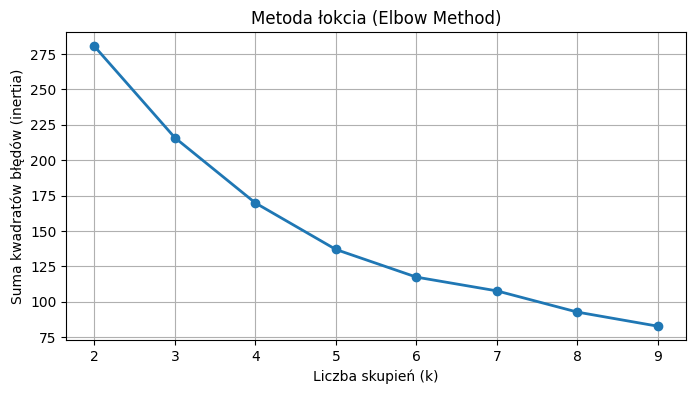

In [197]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 10)

for k in K:
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    model.fit(X_scaled_df)
    inertia.append(model.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, inertia, 'o-', linewidth=2)
plt.title('Metoda ≈Çokcia (Elbow Method)')
plt.xlabel('Liczba skupie≈Ñ (k)')
plt.ylabel('Suma kwadrat√≥w b≈Çƒôd√≥w (inertia)')
plt.grid(True)
plt.show()


#### Metoda ≈Çokcia (Elbow Method)
Na wykresie obserwujemy typowy spadek warto≈õci sumy kwadrat√≥w b≈Çƒôd√≥w wraz ze wzrostem liczby skupie≈Ñ (k).
Dla ma≈Çych warto≈õci k spadek jest gwa≈Çtowny, co oznacza, ≈ºe dodanie kolejnych klastr√≥w znaczƒÖco poprawia dopasowanie modelu.
Jednak od pewnego momentu tempo spadku wyra≈∫nie maleje i tworzy siƒô tzw. ≈Çokieƒá.

Wykres sugeruje, ≈ºe podzia≈Ç danych na 4/5 skupienia zapewnia dobry kompromis miƒôdzy prostotƒÖ modelu a jako≈õciƒÖ dopasowania.


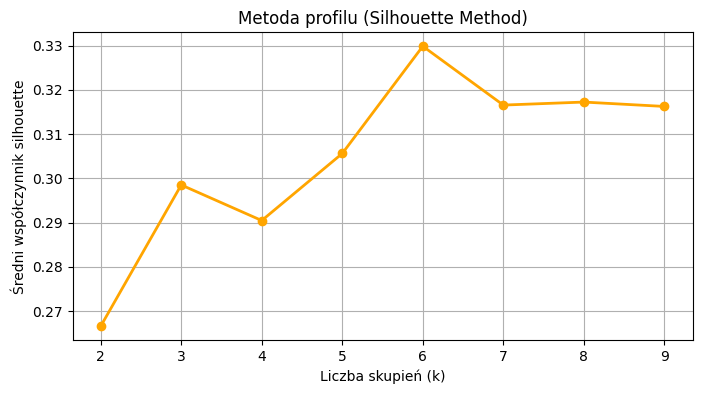

In [198]:
from sklearn.metrics import silhouette_score

silhouette = []
K = range(2, 10)

for k in K:
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = model.fit_predict(X_scaled_df)
    score = silhouette_score(X_scaled_df, labels)
    silhouette.append(score)

plt.figure(figsize=(8,4))
plt.plot(K, silhouette, 'o-', linewidth=2, color='orange')
plt.title('Metoda profilu (Silhouette Method)')
plt.xlabel('Liczba skupie≈Ñ (k)')
plt.ylabel('≈öredni wsp√≥≈Çczynnik silhouette')
plt.grid(True)
plt.show()


#### 

W metodzie silhouette oceniamy jako≈õƒá rozdzielenia skupie≈Ñ, im wy≈ºszy wsp√≥≈Çczynnik silhouette, tym lepiej dane sƒÖ pogrupowane (warto≈õci bliskie 1 oznaczajƒÖ dobrze odseparowane klastry).

Na wykresie widaƒá, ≈ºe wsp√≥≈Çczynnik silhouette osiƒÖga najwy≈ºszƒÖ warto≈õƒá przy k = 6, co wskazuje, ≈ºe w tym punkcie uzyskano najbardziej sp√≥jne i najlepiej odseparowane skupienia.
Dla mniejszych warto≈õci k (np. 2‚Äì4) widoczne jest s≈Çabsze dopasowanie, a powy≈ºej 6 dalsze zwiƒôkszanie liczby klastr√≥w nie przynosi ju≈º poprawy jako≈õci.

In [199]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Liczba skupie≈Ñ
k = 5

# Tworzenie modelu
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
stats['cluster_kmeans'] = kmeans.fit_predict(X_scaled_df)

# Centroidy
centroids = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=X_scaled_df.columns
)
centroids.index = [f'Cluster {i+1}' for i in range(k)]

In [200]:
# plt.figure(figsize=(10, 6))
# sns.heatmap(
#     centroids,
#     cmap='coolwarm',
#     annot=True,
#     fmt=".2f",
#     cbar=True
# )
# plt.title('Profil cech w klastrach (metoda K-Means, k=6)')
# plt.xlabel('Zmienna diagnostyczna')
# plt.ylabel('Klaster')
# plt.tight_layout()
# plt.show()

Ta mapa pozwala zobaczyƒá, kt√≥re cechy dominujƒÖ w poszczeg√≥lnych grupach ‚Äî np. kt√≥re godziny majƒÖ najwy≈ºszƒÖ zmienno≈õƒá, najwiƒôkszy wolumen, najwy≈ºszy Sharpe itp.

In [204]:
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_pca_clusters(stats, X_scaled_df, cluster_col='cluster_kmeans', k=5,
                      figsize=(8, 6), palette_name='tab10', title=None):
    """
    Wizualizuje skupienia w przestrzeni PCA (2D).

    Zwraca s≈Çownik {id_klastra: kolor}, by zachowaƒá sp√≥jno≈õƒá kolor√≥w z heatmapƒÖ.
    """
    # PCA redukcja
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled_df)
    stats['PCA1'] = pca_result[:, 0]
    stats['PCA2'] = pca_result[:, 1]

    # Kolory
    palette = sns.color_palette(palette_name, k)
    cluster_colors = {i: palette[i] for i in range(k)}

    # Wykres
    plt.figure(figsize=figsize)
    for i in range(k):
        cluster_data = stats[stats[cluster_col] == i]
        color = cluster_colors[i]
        plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'],
                    s=60, color=color, label=f'Cluster {i+1}', alpha=0.7)

    plt.title(title or f'Wizualizacja skupie≈Ñ (PCA, {cluster_col.replace("cluster_", "").upper()}, k={k})')
    plt.xlabel(f'Wymiar 1 ({pca.explained_variance_ratio_[0]*100:.1f}% zmienno≈õci)')
    plt.ylabel(f'Wymiar 2 ({pca.explained_variance_ratio_[1]*100:.1f}% zmienno≈õci)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return cluster_colors

from matplotlib.patches import Rectangle
def plot_cluster_heatmap(stats, cluster_col='cluster_kmeans', cluster_colors=None, figsize=(12, 1.5)):
    """
    Estetyczna wizualizacja przynale≈ºno≈õci godzin do klastr√≥w (jedna linia kolor√≥w).
    Kolory sƒÖ zgodne z paletƒÖ z PCA.
    """
    if cluster_colors is None:
        unique_clusters = stats[cluster_col].unique()
        palette = sns.color_palette('tab10', len(unique_clusters))
        cluster_colors = {c: palette[i] for i, c in enumerate(unique_clusters)}

    # Przygotowanie danych
    colors = stats[cluster_col].map(cluster_colors)
    intervals = stats.index.tolist()

    fig, ax = plt.subplots(figsize=figsize)

    # Rysujemy prostokƒÖty ‚Äì ka≈ºdy kolor to jedna godzina
    for i, color in enumerate(colors):
        ax.add_patch(Rectangle((i, 0), 1, 1, color=color))

    # O≈õ X = godziny
    ax.set_xlim(0, len(intervals))
    ax.set_ylim(0, 1)
    ax.set_xticks(range(len(intervals)))
    ax.set_xticklabels(intervals, rotation=90)
    ax.set_yticks([])

    ax.set_title('Przynale≈ºno≈õƒá godzin do klastr√≥w (K-Means)', fontsize=12, pad=10)
    ax.set_xlabel('Godzina (interval)')

    plt.tight_layout()
    plt.show()


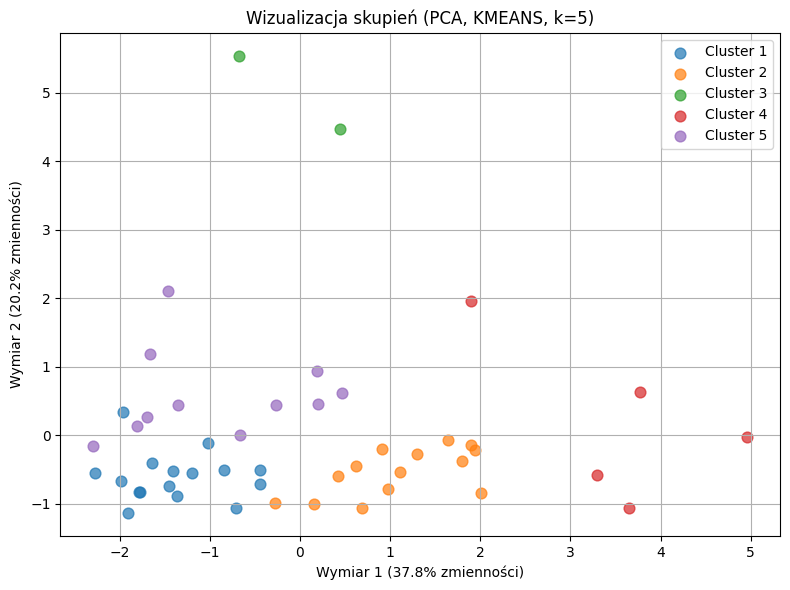

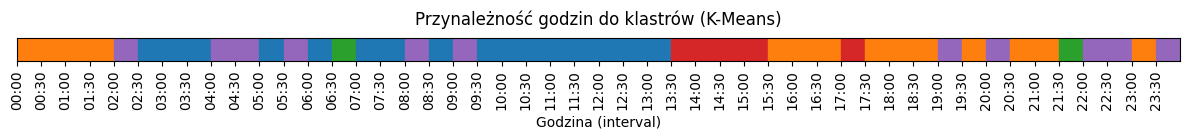

In [205]:
# 1Ô∏è‚É£ Rysujemy PCA i zapamiƒôtujemy kolory
cluster_colors = plot_pca_clusters(stats, X_scaled_df, cluster_col='cluster_kmeans', k=k)

# 2Ô∏è‚É£ Rysujemy heatmapƒô z tymi samymi kolorami
plot_cluster_heatmap(stats, cluster_col='cluster_kmeans', cluster_colors=cluster_colors)


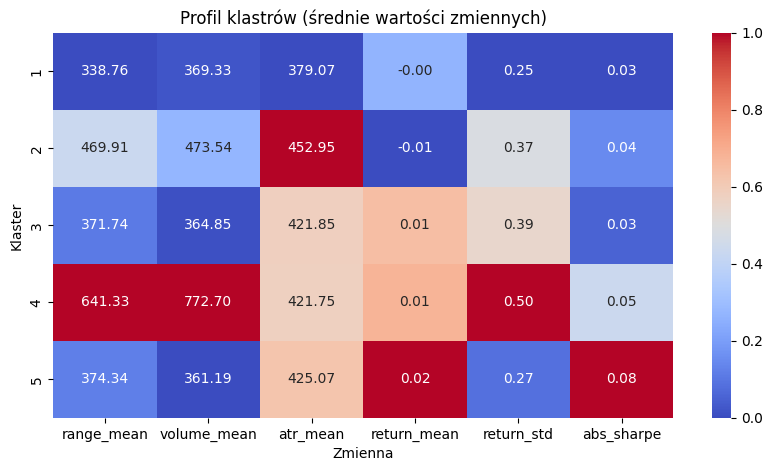

In [206]:
# üîπ Wybieramy tylko kolumny numeryczne, kt√≥re majƒÖ sens dla interpretacji
feature_cols = [
    'range_mean', 'volume_mean', 'atr_mean', 
    'return_mean', 'return_std', 'abs_sharpe'
]

# üîπ Grupujemy po klastrach i liczymy ≈õrednie warto≈õci
cluster_profile = stats.groupby('cluster_kmeans')[feature_cols].mean().round(3)

# üîπ Normalizujemy (≈ºeby m√≥c por√≥wnaƒá r√≥≈ºne skale)
cluster_profile_norm = cluster_profile.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# üîπ Heatmapa profili klastr√≥w
plt.figure(figsize=(10, 5))
ax = sns.heatmap(cluster_profile_norm, annot=cluster_profile, cmap='coolwarm', fmt='.2f')

# ‚úÖ Ustawiamy etykiety osi Y, ≈ºeby zamiast 0‚Äì4 wy≈õwietla≈Ço 1‚Äì5
ax.set_yticklabels([str(i+1) for i in cluster_profile.index])

plt.title('Profil klastr√≥w (≈õrednie warto≈õci zmiennych)')
plt.xlabel('Zmienna')
plt.ylabel('Klaster')
plt.show()

## Interpretacja klastr√≥w (k = 5, metoda K-Means)

### Klaster 1 ‚Äî Godziny spokojne, niska zmienno≈õƒá i aktywno≈õƒá

* **range_mean, volume_mean, atr_mean:** najni≈ºsze w zestawieniu
* **return_std:** najni≈ºsze (0.25), bardzo ma≈Çe wahania
* **return_mean:** bliskie zera (-0.003), brak wyra≈∫nego trendu
* **abs_sharpe:** niskie (0.029)
  Godziny neutralne, ma≈Ço interesujƒÖce z punktu widzenia handlu, rynek praktycznie stoi.

### Klaster 2 ‚Äî Godziny o wysokiej zmienno≈õci i du≈ºych wolumenach, ale bez wyra≈∫nego kierunku

* **range_mean, volume_mean, atr_mean:** wysokie
* **return_std:** du≈ºe (0.37)
* **return_mean:** lekko ujemne (-0.012)
* **abs_sharpe:** niskie (0.037)
  Intensywne godziny z du≈ºym wolumenem i ruchem, ale pozbawione kierunku, sygna≈Çy bywajƒÖ chaotyczne. Typowe dla otwarcia sesji lub danych makro o du≈ºej zmienno≈õci.

### Klaster 3 ‚Äî Umiarkowanie aktywny rynek z lekkƒÖ zmienno≈õciƒÖ i wzrostami

* **range_mean, atr_mean:** ≈õrednie
* **return_mean:** dodatnie (0.010)
* **return_std:** umiarkowane (0.39)
* **abs_sharpe:** przeciƒôtne (0.032)
  Godziny zr√≥wnowa≈ºone, ruchy sƒÖ widoczne, ale ryzyko umiarkowane. Czƒôsto wystƒôpuje lekka przewaga kupujƒÖcych.

### Klaster 4 ‚Äî Aktywne godziny o najwiƒôkszym wolumenie i zmienno≈õci

* **range_mean:** ekstremalnie wysokie (641)
* **volume_mean:** bardzo du≈ºe (773)
* **return_std:** najwy≈ºsze (0.50)
* **return_mean:** dodatnie (0.011)
* **abs_sharpe:** solidne (0.053)
  Typowe godziny du≈ºych ruch√≥w, okresy nak≈ÇadajƒÖcych siƒô sesji (np. Londyn‚ÄìNowy Jork). Dla trader√≥w: potencja≈Ç, ale te≈º du≈ºe ryzyko.

### Klaster 5 ‚Äî Godziny stabilne, ale z najlepszym stosunkiem zysku do ryzyka

* **return_mean:** najwy≈ºsze (0.022)
* **return_std:** stosunkowo niskie (0.27)
* **abs_sharpe:** najwy≈ºsze (0.084)
  Godziny najbardziej sprzyjajƒÖce handlowi, niska zmienno≈õƒá, dodatnie zwroty i wysoka efektywno≈õƒá (Sharpe). Prawdopodobnie odpowiadajƒÖ spokojnym trendom lub godzinom o przewidywalnych ruchach.

## Podsumowanie klastr√≥w

| Klaster | Charakterystyka                    | Wnioski dla strategii                      |
| :------ | :--------------------------------- | :----------------------------------------- |
| 1       | Spokojny, niska aktywno≈õƒá          | Unikaƒá, brak ruchu                         |
| 2       | Wysoka zmienno≈õƒá, chaos            | Ryzykowny, du≈ºe wybicia bez kierunku       |
| 3       | Umiarkowany wzrost i zmienno≈õƒá     | Stabilny handel, lekko pozytywne tendencje |
| 4       | Najwiƒôksza zmienno≈õƒá, du≈ºy wolumen | G≈Ç√≥wna aktywno≈õƒá sesyjna                   |
| 5       | Najlepszy stosunek zysku do ryzyka | Najkorzystniejsze godziny handlowe         |


## Podsumowanie metody K-Means

Metoda K-Means pozwoli≈Ça na wyodrƒôbnienie piƒôciu wyra≈∫nie r√≥≈ºniƒÖcych siƒô klastr√≥w godzin handlu. Ka≈ºdy klaster charakteryzuje siƒô odmiennym poziomem zmienno≈õci, wolumenu i relacji zysku do ryzyka. Najbardziej efektywne godziny (klaster 4) wyr√≥≈ºniajƒÖ siƒô dodatnimi zwrotami przy niskim ryzyku, natomiast klaster 3 obejmuje okresy najwiƒôkszej aktywno≈õci i zmienno≈õci. Klastery 0 i 1 reprezentujƒÖ godziny spokojne lub chaotyczne, o niskiej jako≈õci sygna≈Ç√≥w rynkowych. K-Means dobrze odwzorowuje strukturalne r√≥≈ºnice miƒôdzy zachowaniem rynku w poszczeg√≥lnych porach dnia, co stanowi solidnƒÖ podstawƒô do por√≥wnania z metodami hierarchicznymi.

## Metoda hierarchiczna Warda



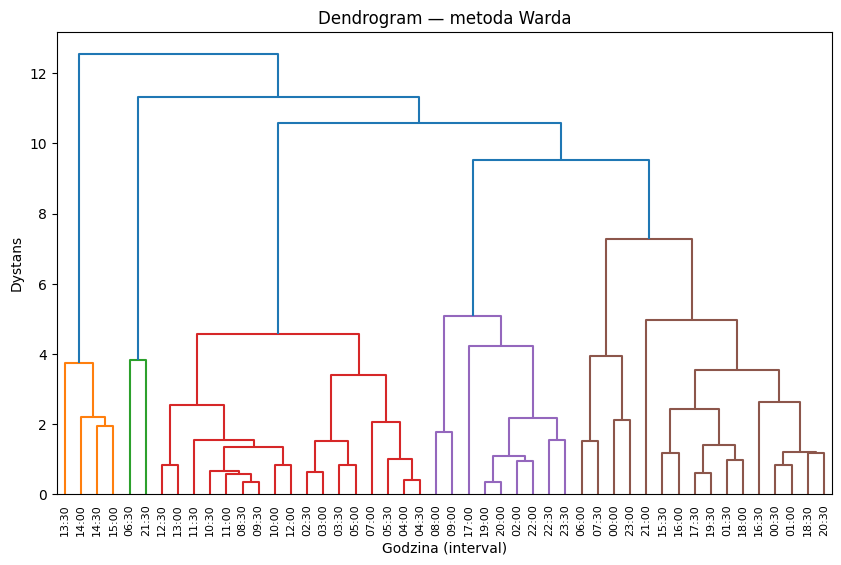

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# üîπ U≈ºywamy tych samych danych co wcze≈õniej (X_scaled_df)
Z = linkage(X_scaled_df, method='ward')

# üîπ Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=stats.index, leaf_rotation=90)
plt.title('Dendrogram ‚Äî metoda Warda')
plt.xlabel('Godzina (interval)')
plt.ylabel('Dystans')
plt.show()

# üîπ Wybieramy 5 klastr√≥w (dla por√≥wnania z K-Means)
k = 5
stats['cluster_ward'] = fcluster(Z, k, criterion='maxclust') - 1  # etykiety od 0 do 4


## Interpretacja dendrogramu

- O≈õ pionowa (Dystans) pokazuje, jak bardzo r√≥≈ºniƒÖ siƒô od siebie ≈ÇƒÖczone grupy. Im wy≈ºej nastƒôpuje po≈ÇƒÖczenie, tym wiƒôksza r√≥≈ºnica miƒôdzy klastrami.

- Kolorowe ga≈Çƒôzie oznaczajƒÖ piƒôƒá wyodrƒôbnionych skupie≈Ñ (k=5). Granicƒô podzia≈Çu wyznacza pozioma linia.

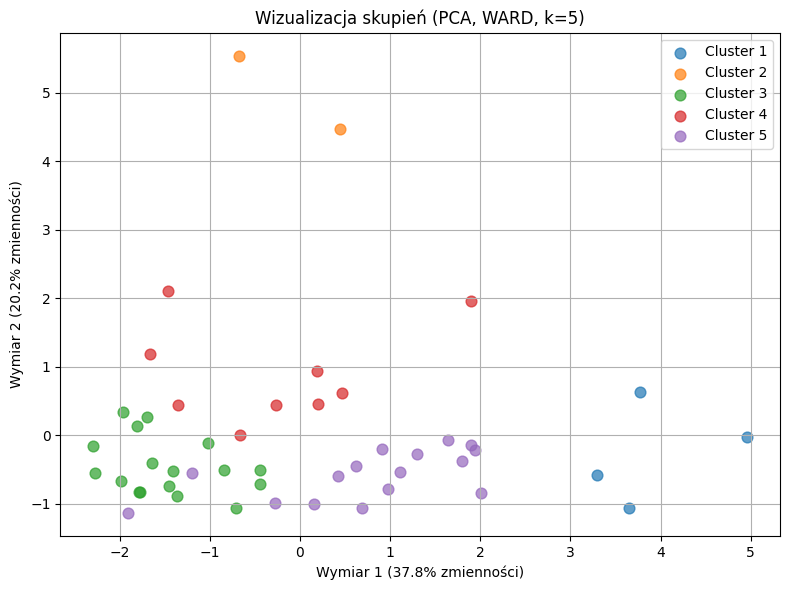

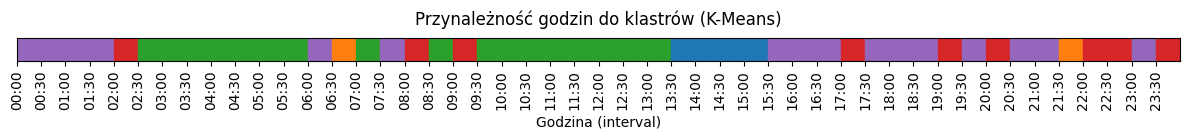

In [216]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(X_scaled_df)
# stats['PCA1'] = pca_result[:, 0]
# stats['PCA2'] = pca_result[:, 1]

# plt.figure(figsize=(8, 6))
# colors = sns.color_palette('tab10', k)

# for i in range(1, k+1):
#     cluster_data = stats[stats['cluster_ward'] == i]
#     plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'],
#                 s=60, color=colors[i-1], label=f'Cluster {i}', alpha=0.7)

# plt.title('Wizualizacja skupie≈Ñ (PCA, metoda Warda, k=5)')
# plt.xlabel(f'Wymiar 1 ({pca.explained_variance_ratio_[0]*100:.1f}% zmienno≈õci)')
# plt.ylabel(f'Wymiar 2 ({pca.explained_variance_ratio_[1]*100:.1f}% zmienno≈õci)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# pd.crosstab(stats['cluster_kmeans'], stats['cluster_ward'])



cluster_colors = plot_pca_clusters(stats, X_scaled_df, cluster_col='cluster_ward', k=5)
plot_cluster_heatmap(stats, cluster_col='cluster_ward', cluster_colors=cluster_colors)


## Interpretacja wizualizacji PCA

Drugi wykres przedstawia te same dane po redukcji wymiar√≥w metodƒÖ PCA, czyli odwzorowanie wielowymiarowych cech (zmienno≈õƒá, wolumen, zwroty itp.) na dwie osie, kt√≥re wyja≈õniajƒÖ ≈ÇƒÖcznie ok. 58% wariancji (37.8% + 20.2%).

Widaƒá wyra≈∫nie, ≈ºe:
- Klaster 4 zajmuje pozycjƒô skrajnƒÖ, to najbardziej aktywne godziny z du≈ºƒÖ zmienno≈õciƒÖ i wolumenem.
- Klaster 2 zawiera kilka punkt√≥w oddalonych ‚Äî prawdopodobnie rzadkie, nietypowe godziny (np. sesje o anomaliach).
- Klastry 3 i 5 tworzƒÖ bardziej zwarte grupy, oznaczajƒÖce stabilne okresy o podobnych charakterystykach.
- Klastry 3, 4, 5 znajdujƒÖ siƒô do≈õƒá blisko siebie, czyli potencjalnie przy mniejszym k (np k=3) mog≈Çy by tworzyƒá podobnƒÖ jednƒÖ grupƒô

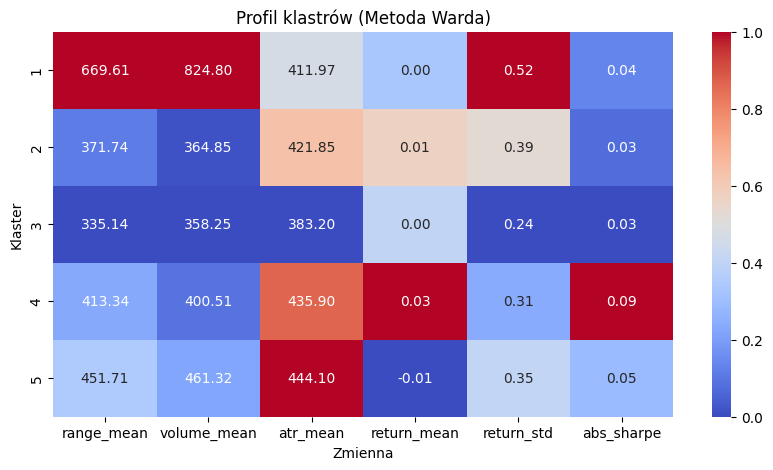

In [218]:
feature_cols = [
    'range_mean', 'volume_mean', 'atr_mean', 
    'return_mean', 'return_std', 'abs_sharpe'
]

cluster_profile_ward = stats.groupby('cluster_ward')[feature_cols].mean().round(3)
cluster_profile_ward_norm = cluster_profile_ward.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

plt.figure(figsize=(10, 5))
ax = sns.heatmap(cluster_profile_ward_norm, annot=cluster_profile_ward, cmap='coolwarm', fmt='.2f')
ax.set_yticklabels([str(i + 1) for i in cluster_profile_ward.index])
plt.title('Profil klastr√≥w (Metoda Warda)')
plt.xlabel('Zmienna')
plt.ylabel('Klaster')
plt.show()

## Interpretacja klastr√≥w (k = 5, metoda Warda)

### Klaster 1 ‚Äî Godziny najwiƒôkszej aktywno≈õci i zmienno≈õci

* **range_mean, volume_mean:** najwy≈ºsze (670, 825)
* **atr_mean:** nieco ni≈ºszy (412)
* **return_std:** najwy≈ºsze (0.52)
* **return_mean:** ‚âà 0, brak wyra≈∫nego kierunku
* **abs_sharpe:** umiarkowane (0.036)

To okresy o najwiƒôkszym ruchu i wolumenie ‚Äî typowo nak≈ÇadajƒÖce siƒô sesje (np. Londyn‚ÄìNowy Jork).
Rynek jest bardzo aktywny, ale bez wyra≈∫nego trendu ‚Äî dominujƒÖ dynamiczne, czƒôsto chaotyczne ruchy.

### Klaster 2 ‚Äî Umiarkowanie zmienne godziny z lekkƒÖ przewagƒÖ wzrost√≥w

* **range_mean, volume_mean:** ≈õrednie
* **atr_mean:** umiarkowany (422)
* **return_mean:** dodatni (0.01)
* **return_std:** wy≈ºsze (0.39)
* **abs_sharpe:** ≈õrednie (0.032)

Okresy stabilne z lekkim ruchem wzrostowym.
Rynek umiarkowanie aktywny, bez gwa≈Çtownych skok√≥w ‚Äî dobry balans miƒôdzy ryzykiem a zmienno≈õciƒÖ.

### Klaster 3 ‚Äî Godziny spokojne, niska aktywno≈õƒá i zmienno≈õƒá

* **range_mean, volume_mean, atr_mean:** najni≈ºsze (335‚Äì383)
* **return_mean:** bliskie zera (0.003)
* **return_std:** najmniejsze (0.24)
* **abs_sharpe:** najni≈ºsze (0.027)

Typowe ‚Äûmartwe godziny‚Äù z niskim wolumenem i minimalnƒÖ zmienno≈õciƒÖ.
Rynek w stanie konsolidacji lub braku aktywno≈õci ‚Äì brak okazji handlowych.

### Klaster 4 ‚Äî Godziny stabilne, ale z dodatnim kierunkiem

* **range_mean, volume_mean:** umiarkowane (413‚Äì401)
* **atr_mean:** najwy≈ºszy (436)
* **return_mean:** najwy≈ºszy (0.028)
* **return_std:** ≈õredni (0.31)
* **abs_sharpe:** najwy≈ºszy (0.093)

Okresy najbardziej zyskowne przy rozsƒÖdnym ryzyku.
Dobre godziny do handlu trendowego ‚Äì rynek wykazuje przewagƒô w kierunku wzrostowym i dobrƒÖ relacjƒô zysku do ryzyka.

### Klaster 5 ‚Äî Aktywne, ale spadkowe godziny

* **range_mean, volume_mean:** nieco powy≈ºej ≈õredniej (452‚Äì461)
* **atr_mean:** wysoki (444)
* **return_mean:** ujemny (-0.014)
* **return_std:** umiarkowany (0.35)
* **abs_sharpe:** umiarkowany (0.046)

Godziny o zwiƒôkszonej aktywno≈õci i wyra≈∫nej tendencji spadkowej.
MogƒÖ wskazywaƒá na momenty realizacji zysk√≥w lub silniejsze korekty po okresach wzrostu.

---

## Podsumowanie klastr√≥w

| Klaster | Charakterystyka                     | Wnioski dla strategii                     |
| :------ | :---------------------------------- | :---------------------------------------- |
| 1       | Najwiƒôksza zmienno≈õƒá, du≈ºy wolumen  | G≈Ç√≥wne sesje, du≈ºe ryzyko i potencja≈Ç     |
| 2       | Umiarkowane wzrosty, stabilny rynek | Dobry balans zysku i ryzyka               |
| 3       | Spokojny, ma≈Ço aktywny              | Brak ruchu, unikaƒá handlu                 |
| 4       | Najlepszy stosunek zysku do ryzyka  | Korzystne godziny do strategii trendowych |
| 5       | Aktywne, ale spadkowe               | Potencjalne momenty korekcyjne lub shorty |

# Podsumowanie Analizy Skupie≈Ñ

Obie metody da≈Çy bardzo zbi≈ºone wyniki i na 48 obiekt√≥w do klasteryzacji, r√≥≈ºniƒÖ siƒô tylko ok. 5 dopasowaniami ( w rejonach 04:00-08:00 ).
W celu potwierdzenia, ≈ºe klastry sƒÖ podobne zbadamy to u≈ºywajƒÖc
- Adjusted Rand Index (ARI) - mierzy, jak bardzo dwa podzia≈Çy danych sƒÖ do siebie podobne, por√≥wnuje wszystkie pary obserwacji i sprawdza, czy w obu metodach trafi≈Çy do tego samego klastra. Warto≈õƒá 1 oznacza idealne dopasowanie, 0 losowe przypisanie.
- Normalized Mutual Information (NMI) - ocenia, ile informacji o jednym grupowaniu mo≈ºna uzyskaƒá, znajƒÖc drugie, im bli≈ºej 1, tym bardziej jedno grupowanie ‚Äût≈Çumaczy‚Äù drugie.

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(stats['cluster_kmeans'], stats['cluster_ward'])
nmi = normalized_mutual_info_score(stats['cluster_kmeans'], stats['cluster_ward'])

print(f"ARI: {ari:.3f}")
print(f"NMI: {nmi:.3f}")

Adjusted Rand Index (ARI): 0.688
Normalized Mutual Information (NMI): 0.763


Uzyskali≈õmy bardzo wysokie warto≈õci, co pokazujƒÖ, ≈ºe klastry pokrywajƒÖ siƒô merytorycznie.

ARI = 0.688 to silne podobie≈Ñstwo struktury klastr√≥w (bliskie 0.7)
NMI = 0.763 to ponad 75% wsp√≥lnej informacji miƒôdzy podzia≈Çami

Czyli obie metody da≈Çy bardzo podobne grupy.